In [19]:
import numpy as np
import matplotlib.pyplot as plt
from phystem.systems.ring.quantities import grids
from phystem.systems.ring import utils


In [55]:
from pathlib import Path
import yaml

class State:
    def __init__(self, pos, angle, ids) -> None:
        self.pos = pos
        self.angle = angle
        self.ids = ids

def load(root_dir, state_dir="autosave"):
    root = Path(root_dir)/state_dir

    pos = np.load(root/"pos.npy")
    angle = np.load(root/"angle.npy")
    ids = np.load(root/"ids.npy")

    with open(root/"config.yaml") as f:
        configs = yaml.unsafe_load(f)
    
    return State(pos, angle, ids), configs

def get_cm_grid(root_dir, col_shape=1, state_dir="autosave"):
    state, cfg = load(root_dir, state_dir)
    space = cfg["space_cfg"]

    r = utils.get_ring_radius(
        p_diameter=cfg["dynamic_cfg"].diameter,
        num_particles=cfg["creator_cfg"].num_p)
    
    num_cols = int(space.length/(col_shape*2*r))
    grid = grids.RegularGrid(space.length, space.height, num_cols, 1)

    return utils.get_cm(state.pos), grid

def get_density(cm, grid: grids.RegularGrid):
    return grid.count(grid.coords(cm))

In [76]:
root_dir = [
    "data/init_state_low_flux_force",
    "../input_pars/data/low_adh_align_flux",
    "../input_pars/data/little_adh_1",
    "../input_pars/data/little_adh_3",
]
names = [
    "Inicial",
    "Adesão: 0",
    "Adesão: 1",
    "Adesão: 3",
]

col_shape = 4
save_dir = "/home/marcos/Desktop"
to_save = False

cfgs = load(root_dir[1])[1]
space = cfgs["space_cfg"] 
r = utils.get_ring_radius(
    p_diameter=cfgs["dynamic_cfg"].diameter,
    num_particles=cfgs["creator_cfg"].num_p)
    
cms, grid_list, densitys = [], [], []

for idx, rd in enumerate(root_dir):
    state_dir = "autosave"
    if idx == 0:
        state_dir = "checkpoint"
    cm, grid = get_cm_grid(rd, col_shape=col_shape, state_dir=state_dir)
    
    cms.append(cm)
    grid_list.append(grid)

    densitys.append(get_density(cm, grid))

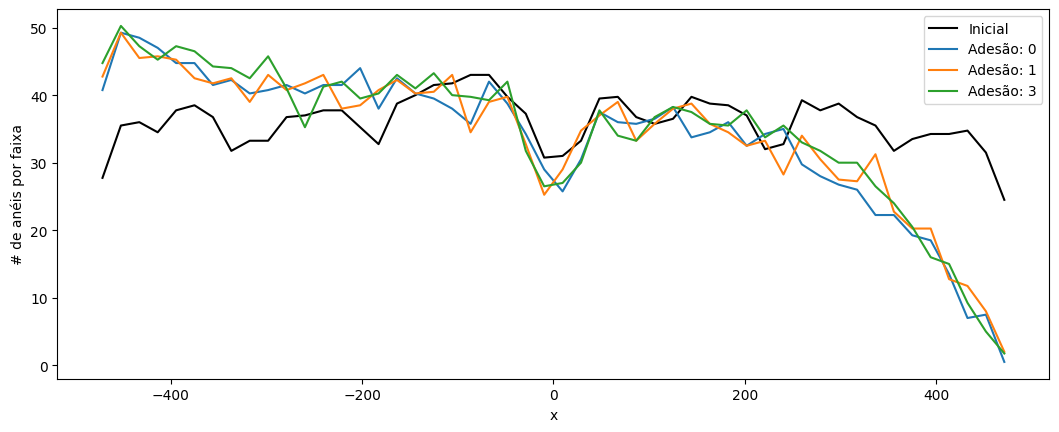

In [77]:
def get_sum_arr(arr, kernel_size):
    from math import floor

    num_points = arr.size // kernel_size
    new_arr = np.zeros(num_points, dtype=arr.dtype)
    start_id = 0
    for i in range(num_points):
        end_id = start_id + kernel_size 
        new_arr[i] = arr[start_id:end_id].sum()
        start_id = end_id 
    
    return new_arr

def density_graph(ax, fig, grid, density, label, c=None):
    ax.plot(grid.dim_cell_center[0], density[0]/col_shape, label=label, c=c)

    cmap_amp = 0.7
    # density_graph = ax.pcolormesh(*grid.edges, density/density_eq - 1, shading='flat', cmap="coolwarm", vmin=-cmap_amp, vmax=cmap_amp)
    # fig.colorbar(density_graph, label="Densidade Relativa")

fig, ax = plt.subplots()
w, h = fig.get_size_inches()
fig.set_size_inches(w*2, h)

density_eq = space.height/(2*r)

# ax.set_title(title)
# ax.set_ylim(0, density_eq*1.1)
ax.set_xlabel("x")
ax.set_ylabel("# de anéis por faixa")

for idx, (g, den, name) in enumerate(zip(grid_list, densitys, names)):
    c = None
    if idx == 0:
        c = "black"
    density_graph(ax, fig, g, den, name, c=c)

ax.legend()

if to_save:
    plt.savefig(Path(save_dir)/f"density_f{flux}.png")
else:
    plt.show()